### Carregando os Módulos

In [1]:
%matplotlib inline
from matplotlib.pyplot import plot
import numpy as np
import random

from neupy import environment, algorithms, layers, plots
from neupy.exceptions import StopTraining

from sklearn import datasets, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import theano


theano.config.floatX = 'float32'

environment.reproducible()

### Carregando Dataset

In [2]:
digits = np.loadtxt('exdata.csv', delimiter=',')

data = digits[:-1].T
target = digits[-1]

target[target == 10] = 0

### Normalizando os Dados

In [3]:
data_scaler = StandardScaler()
data_normalized = data_scaler.fit_transform(data)

target_scaler = OneHotEncoder()
target_normalized = target_scaler.fit_transform(target.reshape((-1, 1))).todense()


Para normalizar os dados foi utilizada a classe StandardScaler que permite guardar os parâmetros utilizados para pode reverter a normalização dos dados ou utilizar a mesma normalização em outros dados. Para normalizar é calculado a média e desvio padrão para criar os parâmetros. O método fit_transform realiza o cálculo e a normalização.
    
A normalização da saída é feita utilizando OneHotEncoder, que transforma aquela saída única em um vetor colocando 0 paras as outras possíveis saídas da rede e 1 para a saída correta.

### Separando os Dados em Treinamento e Teste

In [4]:
data_train, data_test, target_train, target_test = train_test_split(
    data_normalized,
    target_normalized,
    train_size=(85/100),
)


Foi separado 15% dos dados para formarem o conjunto de teste.

### Criando a Rede


A rede é configurada da seguinte forma: a camada de entrada com 400 neurônios, a hidden layer com 35 neurônios e a camada de saída com 10 neurônios, ambas com a função tangente.

O algoritmo de treinamento utilizado foi o MinibatchGradientDescent que é um gradiente descentente divido em batchs para melhoro desempenho. Também foi configurado um objetivo para tentar alcançar um erro de 0.01 e uma taxa de aprendizado de 0.1.

In [5]:
def check_goal(goal):
    def callback(net):
        if net.errors.last() < goal:
            raise StopTraining("Goal reached")

    return callback

net = algorithms.MinibatchGradientDescent(
    [
        layers.Input(00),
        layers.Tanh(35),
        layers.Tanh(10),
    ],
    verbose=True,
    show_epoch=1000,
#     nesterov=True,
    epoch_end_signal=check_goal(0.01),
)


Main information

[ALGORITHM] MinibatchGradientDescent

[OPTION] batch_size = 128
[OPTION] verbose = True
[OPTION] epoch_end_signal = callback
[OPTION] show_epoch = 1000
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.06 seconds


In [6]:
net.architecture()


Network's architecture

-----------------------------------------------
| # | Input shape | Layer Type | Output shape |
-----------------------------------------------
| 1 | 400         | Input      | 400          |
| 2 | 400         | Tanh       | 35           |
| 3 | 35          | Tanh       | 10           |
-----------------------------------------------



### Treinando a Rede


Ao treinar a rede foi estabelecido os sinais de parada de 10000 épocas ou atingir o objetivo para o erro já estabelecido acima de 0.01.

In [7]:
net.train(data_train, target_train, data_test, target_test, epochs=10000)


Start training

[TRAINING DATA] shapes: (4250, 400)
[TEST DATA] shapes: (750, 400)
[TRAINING] Total epochs: 10000

------------------------------------------------
| Epoch # | Train err | Valid err | Time       |
------------------------------------------------
| 1       | 0.3136    | 0.2159    | 38 ms      |
| 1000    | 0.01828   | 0.03366   | 22 ms      |
| 2000    | 0.01553   | 0.03416   | 24 ms      |
| 3000    | 0.0143    | 0.03565   | 24 ms      |
| 4000    | 0.01353   | 0.03722   | 25 ms      |
| 5000    | 0.01296   | 0.03817   | 24 ms      |
| 6000    | 0.01253   | 0.03883   | 24 ms      |
| 7000    | 0.01217   | 0.03935   | 24 ms      |
| 8000    | 0.01189   | 0.03977   | 24 ms      |
| 9000    | 0.01166   | 0.04017   | 24 ms      |
| 10000   | 0.01145   | 0.04064   | 24 ms      |
------------------------------------------------



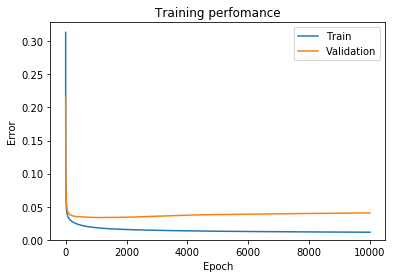

In [8]:
plots.error_plot(net)

### Teste da Rede

#### Teste Utilizando Todos os Dados

In [9]:
predicted = net.predict(data_normalized)
predicted_classes = np.asarray(predicted.argmax(axis=1)).reshape(-1)


Matriz de confusão para todo o conjunto de dados.

In [10]:
metrics.confusion_matrix(target, predicted_classes)

array([[494,   0,   0,   1,   1,   0,   3,   0,   1,   0],
       [  1, 494,   0,   0,   0,   0,   2,   0,   2,   1],
       [  1,   1, 484,   3,   1,   0,   2,   3,   3,   2],
       [  0,   1,   3, 485,   2,   1,   1,   4,   2,   1],
       [  1,   2,   2,   0, 493,   0,   2,   0,   0,   0],
       [  2,   1,   0,   3,   2, 486,   2,   0,   4,   0],
       [  3,   2,   1,   0,   2,   4, 485,   0,   2,   1],
       [  2,   5,   0,   1,   1,   0,   0, 489,   1,   1],
       [  2,   2,   0,   2,   1,   3,   2,   0, 487,   1],
       [  2,   1,   0,   5,   2,   2,   0,   6,   3, 479]])

In [11]:
print(metrics.classification_report(target, predicted_classes))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       500
        1.0       0.97      0.99      0.98       500
        2.0       0.99      0.97      0.98       500
        3.0       0.97      0.97      0.97       500
        4.0       0.98      0.99      0.98       500
        5.0       0.98      0.97      0.98       500
        6.0       0.97      0.97      0.97       500
        7.0       0.97      0.98      0.98       500
        8.0       0.96      0.97      0.97       500
        9.0       0.99      0.96      0.97       500

avg / total       0.98      0.98      0.98      5000



#### Teste Utilizando Apenas o Conjunto de Teste

In [12]:
predicted_test = net.predict(data_test)
predicted_test_classes = np.asarray(predicted_test.argmax(axis=1)).reshape(-1)
target_test_classes = np.asarray(target_test.argmax(axis=1)).reshape(-1)


Matriz de confusão para o conjunto teste.

In [13]:
metrics.confusion_matrix(target_test_classes, predicted_test_classes)

array([[76,  0,  0,  1,  1,  0,  1,  0,  1,  0],
       [ 0, 69,  0,  0,  0,  0,  1,  0,  2,  1],
       [ 1,  0, 58,  3,  1,  0,  0,  3,  3,  2],
       [ 0,  0,  3, 54,  1,  1,  1,  1,  2,  1],
       [ 1,  1,  2,  0, 56,  0,  2,  0,  0,  0],
       [ 1,  1,  0,  2,  1, 80,  0,  0,  4,  0],
       [ 1,  0,  1,  0,  1,  3, 60,  0,  1,  1],
       [ 2,  2,  0,  1,  0,  0,  0, 82,  0,  1],
       [ 1,  1,  0,  2,  1,  2,  1,  0, 72,  1],
       [ 1,  1,  0,  2,  1,  2,  0,  6,  0, 61]])

In [14]:
print(metrics.classification_report(target_test_classes, predicted_test_classes))

             precision    recall  f1-score   support

          0       0.90      0.95      0.93        80
          1       0.92      0.95      0.93        73
          2       0.91      0.82      0.86        71
          3       0.83      0.84      0.84        64
          4       0.89      0.90      0.90        62
          5       0.91      0.90      0.90        89
          6       0.91      0.88      0.90        68
          7       0.89      0.93      0.91        88
          8       0.85      0.89      0.87        81
          9       0.90      0.82      0.86        74

avg / total       0.89      0.89      0.89       750



### Precisão Final

In [15]:
print("Dataset accuracy: {:.2%}".format(
    metrics.accuracy_score(target, predicted_classes)))
print("Test set accuracy: {:.2%}".format(
    metrics.accuracy_score(target_test_classes, predicted_test_classes)))

Dataset accuracy: 97.52%
Test set accuracy: 89.07%
